  Preparing metadata (setup.py) ... done


Saving horse.jpg to horse (5).jpg
⚠️ 沒有找到模型權重，將使用隨機初始化的生成器。


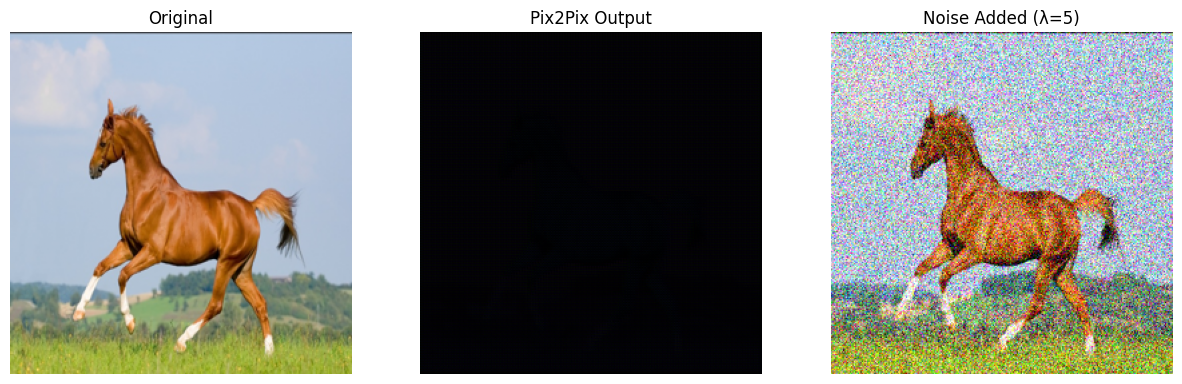

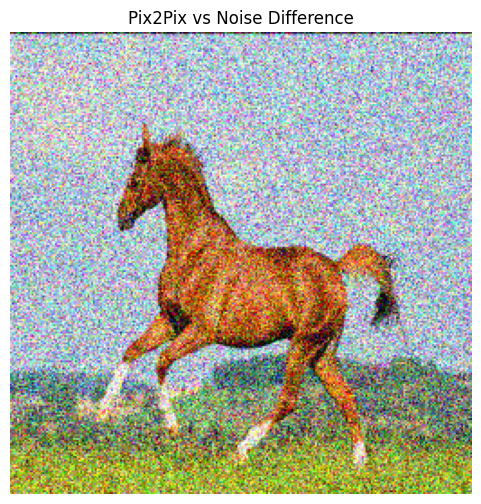

In [ ]:
# 安裝必要套件
!pip install -q git+https://github.com/tensorflow/examples.git

# 匯入套件
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
from google.colab import files
from PIL import Image

# 上傳圖片
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).resize((256, 256))
img = np.array(img) / 255.0
input_image = tf.expand_dims(img, axis=0)

# 建立 pix2pix 生成器
generator = pix2pix.unet_generator(output_channels=3)

# 嘗試載入權重（若無可略過）
try:
    generator.load_weights('your_trained_model_path.h5')
except:
    print("⚠️ 沒有找到模型權重，將使用隨機初始化的生成器。")

# 模擬生成結果（隨機生成或風格轉換）
pix2pix_output = generator(input_image)

# lambda_cycle 控制噪聲強度
lambda_cycle = 5
noise = tf.random.normal(shape=tf.shape(input_image),
                         mean=0.0,
                         stddev=1.0/lambda_cycle,
                         dtype=input_image.dtype)
generated_image = tf.clip_by_value(input_image + noise, 0.0, 1.0)

# 視覺化
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(tf.squeeze(input_image))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Pix2Pix Output")
plt.imshow(tf.squeeze(tf.clip_by_value(pix2pix_output, 0.0, 1.0)))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Noise Added (λ={lambda_cycle})")
plt.imshow(tf.squeeze(generated_image))
plt.axis('off')
plt.show()

# 差異圖
difference_map = tf.abs(tf.cast(pix2pix_output, generated_image.dtype) - generated_image)
plt.figure(figsize=(6,6))
plt.title("Pix2Pix vs Noise Difference")
plt.imshow(tf.squeeze(tf.clip_by_value(difference_map, 0.0, 1.0)))
plt.axis('off')
plt.show()


In [ ]:
!git clone https://github.com/manyapan/facades-dataset.git /content/facades

Cloning into '/content/facades'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# Download the facades dataset
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

--2025-10-09 06:50:42--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   670KB/s    in 58s     

2025-10-09 06:51:41 (507 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



Now, let's define functions to load and preprocess individual images.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)

    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    input_image, real_image = cropped_image[0], cropped_image[1]

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_train_image(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_test_image(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

Finally, let's create the TensorFlow datasets using the defined functions and display an example.

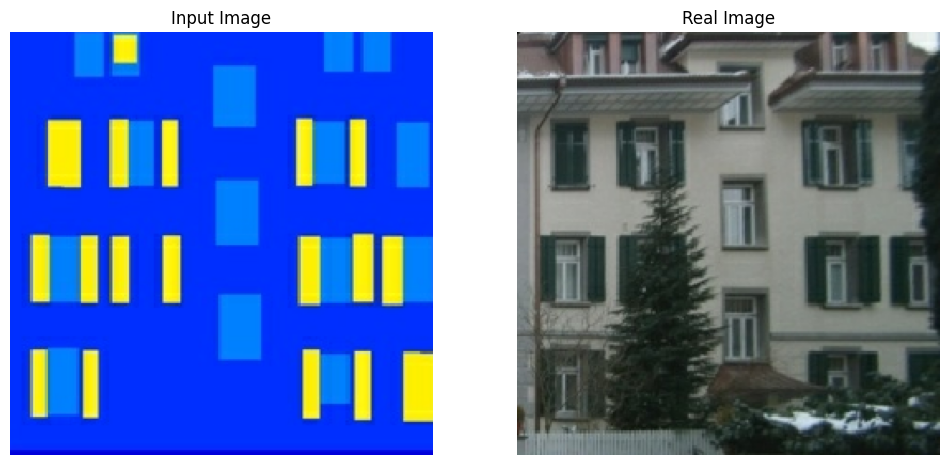

In [ ]:
train_dataset = tf.data.Dataset.list_files('/content/facades/train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files('/content/facades/test/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Display an example from the training dataset
for input_example, real_example in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(input_example[0] * 0.5 + 0.5)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Real Image")
    plt.imshow(real_example[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()